Licensed under the MIT License.

Copyright (c) 2025-2035. All rights reserved by Hanhan Wu.

Permission is hereby granted to view this code for evaluation purposes only.
You may not reuse, copy, modify, merge, publish, distribute, sublicense,
or exploit this code without Hanhan Wu's EXPLICIT written permission.


# AdalFlow on Bigger FIQA Data & Optimize Answer Generation

* Dataset
  * 100 training records
  * 180 validation records
  * 200 testing records
* Optimization
  * teacher generator for few-shot learning
  * backward_engine & optimizer for text_grad optimization
  * Added `self.configure_text_optimizer_helper()` to customize LLM used in the optimization
  * Added `few_shot_demos` to add examples in training, indeed improved the performance here
  * Added `regularization_fn` in `optimizer_config`

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import re
import json
import matplotlib.pyplot as plt
from pprint import pprint
from dataclasses import dataclass, field
from typing import Union, Dict, Callable, Any, Tuple

import adalflow as adal
from adalflow.datasets.hotpot_qa import HotPotQAData
from adalflow.components.model_client.openai_client import OpenAIClient
from adalflow.eval.g_eval import GEvalLLMJudge, GEvalJudgeEvaluator, NLGTask

import warnings
warnings.filterwarnings('ignore')


model_str = "gpt-4.1-nano"
gpt4_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": model_str,
        "temperature": 0.7,
    },
}
model_kwargs = {
        "model": model_str,
        "temperature": 0.7,
    }

### Create Data Input

In [2]:
train_df = pd.read_parquet('final_finance_qa_train.parquet')
val_df = pd.read_parquet('final_finance_qa_val.parquet')
test_df = pd.read_parquet('final_finance_qa_test.parquet')

print(train_df.shape, val_df.shape, test_df.shape)
train_df.head()

(100, 4) (180, 4) (200, 4)


,doc_id,context,question,ground_truth
0,2574.jpeg,[**Document Type:** \nThis is a check issued b...,Who issued the check?,"The Tobacco Institute, located at 1875 I Stree..."
1,4492.jpeg,[### Document Analysis\n\n**Document Type**: C...,What is the type of document being analyzed?,The document is a Check Request Form.
2,7281.jpeg,[**Document Type**: This is a commercial invoi...,What is the name of the organization issuing t...,Philip Morris Limited
3,1242.jpeg,[### Document Type\nThis is a financial docume...,What is the client company for this outdoor ad...,The client company is P.M. Inc.
4,7700.jpeg,[### Document Type\nThis is a Production Estim...,What is the client's name mentioned in the doc...,The client's name is RJR/NOW Family.


In [3]:
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(all_df.shape)
all_df_lst = all_df.to_dict(orient='records')

rag_lst = []
for record in all_df_lst:
    rag_lst.append({
        'question': record['question'],
        'context': record['context'],
        'ground_truth': record['ground_truth']
    })

rag_df = pd.DataFrame(rag_lst)
print(rag_df.shape)
rag_df.head()

(480, 4)
(480, 3)


,question,context,ground_truth
0,Who issued the check?,[**Document Type:** \nThis is a check issued b...,"The Tobacco Institute, located at 1875 I Stree..."
1,What is the type of document being analyzed?,[### Document Analysis\n\n**Document Type**: C...,The document is a Check Request Form.
2,What is the name of the organization issuing t...,[**Document Type**: This is a commercial invoi...,Philip Morris Limited
3,What is the client company for this outdoor ad...,[### Document Type\nThis is a financial docume...,The client company is P.M. Inc.
4,What is the client's name mentioned in the doc...,[### Document Type\nThis is a Production Estim...,The client's name is RJR/NOW Family.


In [4]:
def fiqa_to_hotpotqa(record):
    return HotPotQAData(
        question=record['question'],
        gold_titles=record['ground_truth'],
        context=record['context']
    )

fiqa_as_hotpotqa = [fiqa_to_hotpotqa(s) for s in all_df_lst]
print(len(fiqa_as_hotpotqa))
fiqa_as_hotpotqa[0].to_dict()

480


{'question': 'Who issued the check?',
 'answer': None,
 'id': '0f3db81c-2ac7-417f-9e3c-e4f199331678',
 'gold_titles': 'The Tobacco Institute, located at 1875 I Street, Northwest, Washington, DC 20006.',
 'context': array(['**Document Type:** \nThis is a check issued by The Tobacco Institute.\n\n**Key Details:**\n- **Issuer:** The Tobacco Institute, 1875 I Street, Northwest, Washington, DC 20006\n- **Check Number:** 075013\n- **Date:** September 7, 1990\n- **Payee:** Citizens for Jim Mcpike\n- **Amount:** $500.00\n- **Check Status:** Non-Negotiable\n- **Bank Details:** Check drawn from The National Bank\n\n**Insights and Observations:**\n- The check is marked as non-negotiable, indicating it cannot be transferred and can only be cashed or deposited by the person named (Citizens for Jim Mcpike).\n- The substantial amount (considering the date in 1990) suggests it might have been for a significant expense or donation.\n- As the issuer is The Tobacco Institute, the payment could be related

In [5]:
trainset = fiqa_as_hotpotqa[0:len(train_df)]
valset = fiqa_as_hotpotqa[len(train_df):len(train_df) + len(val_df)]
testset = fiqa_as_hotpotqa[len(train_df) + len(val_df):]
print(len(trainset), len(valset), len(testset))

100 180 200


### AdalFlow Optimization

* References
  * How to use AdalFlow's GEval and LLM-as-Judge: https://colab.research.google.com/github/SylphAI-Inc/AdalFlow/blob/main/notebooks/evaluation/adalflow_llm_eval.ipynb
  * Official evaluation page (I think their user guide is very confusing 😅): https://adalflow.sylph.ai/apis/eval/index.html

In [8]:
task_desc_str = r"""Answer questions with short factoid answers.
                    You will receive context(contain relevant facts).
                    Think step by step.
                """


prompt_template = """<START_OF_SYSTEM_PROMPT>
{{task_desc_str}}

{{output_format_str}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
    Here are some examples:
    {{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
    Context: {{context}}
    Question: {{question}}
<END_OF_USER>
"""


def format_few_shot_demo(example):
    return f"Context: {example.context}\nQuestion: {example.question}\nAnswer: {example.answer}\n"

few_shot_examples = trainset[:10]  # Use first 3 as examples
few_shot_demos_str = "\n---\n".join([format_few_shot_demo(e) for e in few_shot_examples])

In [9]:
@dataclass
class AnswerData(adal.DataClass):
    reasoning: str = field(
        metadata={"desc": "The reasoning to produce the answer"},
    )
    answer: str = field(
        metadata={"desc": "The answer you produced"},
    )

    __output_fields__ = ["reasoning", "answer"]


class RAG_AnswerGeneration(adal.Component):
    def __init__(self, model_client=None, model_kwargs=None):
        super().__init__()

        self.llm_parser = adal.DataClassParser(
            data_class=AnswerData, return_data_class=True, format_type="json"
        )
        self.llm = adal.Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            prompt_kwargs={
                "task_desc_str": adal.Parameter(
                    data=task_desc_str,
                    role_desc="""Task description for the language model,\
                            used with the following template: \
                                {{task_desc_str}} \
                                {{output_format_str}}\
                            <START_OF_USER>
                                Context: {{context}}
                                Question: {{question}}
                            <END_OF_USER>""",
                    param_type=adal.ParameterType.PROMPT,
                    requires_opt=True,
                    instruction_to_backward_engine="""You need find the best way
                            (where does the right answer come from the context) 
                            to extract the RIGHT answer from the context.""",
                    instruction_to_optimizer="""
                        Write ONLY general instructions for answering questions. 
                        Do NOT include any specific answers, facts, or content from the dataset or any query. 
                        Do NOT copy or paraphrase any ground-truth answer. 
                        Your output must be a reusable prompt template, not a response to a specific question.
                    """,
                ),
                "output_format_str": self.llm_parser.get_output_format_str(),
            },
            template=prompt_template,
            output_processors=self.llm_parser,
            use_cache=True,
        )

    def bicall(
        self, 
        question: str, 
        retrieved_context: str,
        id: str = None,
        few_shot_demos: str = None
    ) -> Union[adal.GeneratorOutput, adal.Parameter]:
        """
            This function is used to call the model for both training and eval mode.
        """
        prompt_kwargs = {
            "context": retrieved_context,
            "question": question,
        }
        if few_shot_demos is not None:
            prompt_kwargs["few_shot_demos"] = few_shot_demos
        output = self.llm(prompt_kwargs=prompt_kwargs, id=id)
        return output

In [10]:
# test above RAG_AnswerGeneration logic
random_test_data = fiqa_as_hotpotqa[0].to_dict()

rag = RAG_AnswerGeneration(**gpt4_model)
output = rag.bicall(
    question=random_test_data['question'],
    retrieved_context=random_test_data['context'],
    few_shot_demos=few_shot_demos_str
)
print(output)
pprint(output.data)

GeneratorOutput(id=None, data=AnswerData(reasoning='The context explicitly states that the issuer of the check is The Tobacco Institute, including its address and other details. Since the question asks for the issuer, the answer directly corresponds to this information.', answer='The Tobacco Institute'), error=None, usage=CompletionUsage(completion_tokens=55, prompt_tokens=4761, total_tokens=4816), raw_response='{\n    "reasoning": "The context explicitly states that the issuer of the check is The Tobacco Institute, including its address and other details. Since the question asks for the issuer, the answer directly corresponds to this information.",\n    "answer": "The Tobacco Institute"\n}', metadata=None)
AnswerData(reasoning='The context explicitly states that the issuer of the '
                     'check is The Tobacco Institute, including its address '
                     'and other details. Since the question asks for the '
                     'issuer, the answer directly cor

In [11]:
class HotPotQAAdal(adal.AdalComponent):
    def __init__(
        self,
        backward_engine_model_config: Dict | None = None,
        teacher_model_config: Dict | None = None,
        text_optimizer_model_config: Dict | None = None,
        task: adal.Component | None = None,  # initialized task
    ):
        g_eval = GEvalLLMJudge(default_task=NLGTask.SUMMARIZATION,
                                model_kwargs=model_kwargs)
        g_evaluator = GEvalJudgeEvaluator(llm_judge=g_eval)
        def extract_overall(**kwargs):
            if 'input_str'  in kwargs:
                match = re.search(r"Reference Answer:(.*)Predicted Answer:(.*)", kwargs['input_str'], re.DOTALL)
                if match:
                    reference = match.group(1).strip()
                    predicted = match.group(2).strip()
            else:
                predicted = kwargs.get("y")
                reference = kwargs.get("y_gt")

            input_str = f"Reference Answer: {reference}\nPredicted Answer: {predicted}"
            return g_evaluator.compute_single_item(input_str)["overall"]

        eval_fn = extract_overall
        loss_eval_fn = extract_overall

        loss_fn = adal.EvalFnToTextLoss(
            eval_fn=loss_eval_fn,
            eval_fn_desc="GEval score",
        )
        super().__init__(
            task=task,
            eval_fn=eval_fn,
            loss_eval_fn=loss_eval_fn,
            loss_fn=loss_fn,
            backward_engine_model_config=backward_engine_model_config,
            teacher_model_config=teacher_model_config,
            text_optimizer_model_config=text_optimizer_model_config,
        )
        self.configure_text_optimizer_helper(
            model_client=OpenAIClient(),
            model_kwargs={"temperature": 0.3}
        )

    def prepare_task(self, sample: HotPotQAData) -> Tuple[Callable[..., Any], Dict]:
        task_kwargs = {
            "question": sample.question,
            "retrieved_context": sample.context,
            "id": getattr(sample, "id", None),
            "few_shot_demos": few_shot_demos_str,
        }
        if self.task.training:
            return self.task.forward, task_kwargs
        else:
            return self.task.call, task_kwargs

    def prepare_eval(self, sample: HotPotQAData, y_pred: adal.GeneratorOutput):
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer

        input_str = (
            f"Reference Answer: {sample.gold_titles}\n"
            f"Predicted Answer: {y_label}"
        )

        return self.eval_fn, {'input_str': input_str}


    def prepare_loss_eval(self, sample: Any, y_pred: Any, *args, **kwargs):
        y_label = ""
        if y_pred and y_pred.data and y_pred.data.answer:
            y_label = y_pred.data.answer

        input_str = (
            f"Reference Answer: {sample.gold_titles}\n"
            f"Predicted Answer: {y_label}"
        )

        return self.loss_eval_fn, {'input_str': input_str}


    def prepare_loss(self, sample: HotPotQAData, pred: adal.Parameter):
        y_gt = adal.Parameter(
            name="y_gt",
            data=sample.gold_titles,
            eval_input=sample.gold_titles,
            requires_opt=False,
        )
        context_param = adal.Parameter(
            name="context",
            data=sample.context,
            eval_input=sample.context,  # you could also stringify it if needed
            requires_opt=False,
        )

        pred.eval_input = (
            pred.data.data.answer
            if pred.data and pred.data.data and pred.data.data.answer
            else ""
        )
        return self.loss_fn, {
            "kwargs": {"y": pred, "y_gt": y_gt,
                        "context": context_param},
            "input": {"question": sample.question,
                       "retrieved_context": sample.context},
            "gt": sample.gold_titles,
            "id": sample.id,
        }

<b>Evaluation On Testset Before Optimization</b>

In [12]:
def train_diagnose(model_client, model_kwargs):
    task = RAG_AnswerGeneration(
        model_client=model_client,
        model_kwargs=model_kwargs
    )

    adal_component = HotPotQAAdal(task=task)
    trainer = adal.Trainer(adaltask=adal_component)
    trainer.diagnose(dataset=testset, split="train")


train_diagnose(**gpt4_model)

Generator llm is already registered with jsonl file at C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl


2025-07-27 14:23:07 - [adal.py:852:configure_text_optimizer_helper] - Text optimizer configured for 1 parameters. names: [('llm.task_desc_str', 'Answer questions with short factoid answers.\n                    You will receive context(contain relevant facts).\n                    Think step by step.\n                ')]
2025-07-27 14:23:07 - [trainer.py:227:diagnose] - Checkpoint path: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal


Loading Data: 100%|██████████| 200/200 [00:00<00:00, 6779.22it/s]
Predicting: step(0): 0.8654 across 200 samples, Max potential: 0.8654: 100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
Error loading jsonl file C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl: line contains invalid json: Trailing data (line 46)


Log file C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl is empty. This llm is not called at all.

================== DIAGNOSE REPORT ==================

✔ Split: train
✔ Overall accuracy score: 0.87
✔ Log paths:
  - Log 1: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\VallinaRAGAdal\diagnose_train\llm_call.jsonl

✔ Diagnose report completed successfully!




<b>Training</b>

* Time Cost: 16 min 11sec

In [13]:
def regularization_fn(prompt: str, sample: HotPotQAData) -> float:
    # Penalize if ground-truth answer appears in the prompt
    if sample.answer.strip() in prompt or sample.question.strip() in prompt:
        return 1.0  # High penalty
    return 0.0     # No penalty

optimizer_config = {
    "regularization_fn": regularization_fn,
}

def train(
    task_model_cliet,
    task_model_kwargs,
    optimizer_model_config,
    backward_engine_model_config,
    train_batch_size=4,  # larger batch size is not that effective, probably because of llm's lost in the middle
    raw_shots: int = 0,
    bootstrap_shots: int = 4,
    max_steps=1,
    num_workers=4,
    strategy="constrained",
    optimization_order="sequential",
    debug=False,
    resume_from_ckpt=None,
    exclude_input_fields_from_bootstrap_demos=True,
    seed=10,
    max_proposals_per_step: int = 5,
    disable_backward_gradients: bool = False,
    disable_backward: bool = False,
):
    task = RAG_AnswerGeneration(
        model_client=task_model_cliet,
        model_kwargs=task_model_kwargs
    )

    adal_component = HotPotQAAdal(
        task=task,
        text_optimizer_model_config=optimizer_model_config,
        backward_engine_model_config=backward_engine_model_config,
    )

    trainer = adal.Trainer(
        train_batch_size=train_batch_size,
        optimizer_config = optimizer_config,
        adaltask=adal_component,
        strategy=strategy,
        max_steps=max_steps,
        num_workers=num_workers,
        raw_shots=raw_shots,
        bootstrap_shots=bootstrap_shots,
        debug=debug,
        weighted_sampling=False,
        optimization_order=optimization_order,
        exclude_input_fields_from_bootstrap_demos=exclude_input_fields_from_bootstrap_demos,
        max_proposals_per_step=max_proposals_per_step,
        text_optimizers_config_kwargs={"max_past_history": 5},
        disable_backward_gradients=disable_backward_gradients,
        disable_backward=disable_backward,
    )
    trainer.set_random_seed(seed)
    print(trainer)

    ckpt, _ = trainer.fit(
        train_dataset=trainset,
        val_dataset=valset,
        test_dataset=testset,
        resume_from_ckpt=resume_from_ckpt,
    )
    return ckpt

In [14]:
train(
    task_model_cliet=gpt4_model["model_client"],
    task_model_kwargs=gpt4_model["model_kwargs"],
    optimizer_model_config=gpt4_model,
    backward_engine_model_config=gpt4_model,
    max_steps=12,
)

2025-07-27 14:28:04 - [adal.py:852:configure_text_optimizer_helper] - Text optimizer configured for 1 parameters. names: [('llm.task_desc_str', 'Answer questions with short factoid answers.\n                    You will receive context(contain relevant facts).\n                    Think step by step.\n                ')]
Trainer(
  (adaltask): HotPotQAAdal(
    eval_fn: extract_overall, backward_engine: None, backward_engine_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'gpt-4.1-nano', 'temperature': 0.7}}, teacher_model_config: None, text_optimizer_model_config: {'model_client': OpenAIClient(), 'model_kwargs': {'model': 'gpt-4.1-nano', 'temperature': 0.7}}
    (task): RAG_AnswerGeneration(
      (llm_parser): DataClassParser(
        data_class=AnswerData, format_type=json,            return_data_class=True, input_fields=[],            output_fields=['reasoning', 'answer']
        (_output_processor): JsonParser()
        (output_format_prompt): template: Yo

Loading Data: 100%|██████████| 180/180 [00:00<00:00, 5918.77it/s]
Predicting: step(0): 0.8615 across 180 samples, Max potential: 0.8615: 100%|██████████| 180/180 [03:54<00:00,  1.30s/it]
Loading Data: 100%|██████████| 200/200 [00:00<00:00, 5156.60it/s]
Predicting: step(0): 0.8654 across 200 samples, Max potential: 0.8654: 100%|██████████| 200/200 [00:02<00:00, 71.13it/s] 


Initial validation score: 0.8615123456790121
Initial test score: 0.8654166666666667
2025-07-27 14:32:02 - [trainer.py:2343:_fit_text_grad_constraint] - Fitting using Textual Gradient Descent with constraints
_fit_text_grad_constraint save to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0


Training: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 93.08it/s]


Moving batch eval: EvaluationResult(avg_score=0.95, per_item_scores=[0.95, 0.95, 1.0, 0.9], additional_info=None)
2025-07-27 14:32:09 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.95
Moving batch correct size: 4
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.975
2025-07-27 14:32:09 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.975,0.975
Subset loss backward...
Subset loss backward time: 2.490612745285034
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:32:14 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8081469535827637
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer factual questions concisely and accurately based on provided context. Think step by step to ensure correctness. Do not include extraneous information.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 317.01it/s]
Predicting: step(1): 0.5972 across 2 samples, Max potential: 0.5972: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


2025-07-27 14:32:18 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5972222222222222 <= 0.975



Proposing:  20%|██        | 1/5 [00:06<00:25,  6.35s/it]

Proposal: 2
2025-07-27 14:32:20 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.0578572750091553
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer factual questions precisely based on the given context. Think step by step to ensure accuracy. Do not include extraneous information or opinions.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 252.78it/s]
Predicting: step(1): 0.5972 across 2 samples, Max potential: 0.5972: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


2025-07-27 14:32:23 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5972222222222222 <= 0.975



Proposing:  40%|████      | 2/5 [00:10<00:16,  5.34s/it]

Proposal: 3
2025-07-27 14:32:25 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5760250091552734
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short, factual responses based on provided context. Think step by step and ensure clarity and accuracy.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 143.70it/s]
Predicting: step(1): 0.5972 across 2 samples, Max potential: 0.5972: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


2025-07-27 14:32:26 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5972222222222222 <= 0.975



Proposing:  60%|██████    | 3/5 [00:14<00:08,  4.30s/it]

Proposal: 4
2025-07-27 14:32:28 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6576578617095947
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with brief factual responses based on given contexts. Think step by step to ensure accuracy and clarity.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 188.69it/s]
Predicting: step(1): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


2025-07-27 14:32:29 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  80%|████████  | 4/5 [00:17<00:03,  3.92s/it]

Proposal: 5
2025-07-27 14:32:31 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8261768817901611
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer the specific question by extracting the exact identifier (e.g., invoice number, client name) from the context. Provide only the factual answer without additional commentary. Think step by step to ensure accuracy.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 346.97it/s]
Predicting: step(1): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


2025-07-27 14:32:33 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing: 100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 67.67it/s]


Moving batch eval: EvaluationResult(avg_score=0.9354166666666667, per_item_scores=[0.95, 0.95, 1.0, 0.9, 1.0, 0.8666666666666667, 0.8166666666666667, 1.0], additional_info=None)
2025-07-27 14:32:37 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.9354166666666667
Moving batch correct size: 8
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.975
2025-07-27 14:32:38 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.975,0.975
Subset loss backward...
Subset loss backward time: 2.236931800842285
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:32:41 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4904510974884033
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers. You will receive context (contain relevant facts). Think step by step. The client name mentioned in the document is the answer.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 262.60it/s]
Predicting: step(2): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


2025-07-27 14:32:44 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  20%|██        | 1/5 [00:04<00:18,  4.61s/it]

Proposal: 2
2025-07-27 14:32:46 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7894461154937744
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer questions with short factoid answers. You will receive context (contain relevant facts). Think step by step. Focus on extracting the client's name as explicitly mentioned in the context, such as 'P. M.', and provide it as the answer.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 281.54it/s]
Predicting: step(2): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


2025-07-27 14:32:48 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  40%|████      | 2/5 [00:08<00:12,  4.03s/it]

Proposal: 3
2025-07-27 14:32:50 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.854642391204834
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer the client's name mentioned in the document.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 281.74it/s]
Predicting: step(2): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


2025-07-27 14:32:51 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  60%|██████    | 3/5 [00:11<00:07,  3.71s/it]

Proposal: 4
2025-07-27 14:32:54 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.41121768951416
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer questions with short factoid answers. You will receive context(contain relevant facts). Think step by step. Extract the client name mentioned in the context, especially when explicitly labeled as 'Client:' or similar. Provide only the client name as the answer.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 251.04it/s]
Predicting: step(2): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


2025-07-27 14:32:55 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  80%|████████  | 4/5 [00:15<00:03,  3.73s/it]

Proposal: 5
2025-07-27 14:32:57 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.029759407043457
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer the question by extracting the client name specifically from the context where it is labeled as 'Client'.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 350.64it/s]
Predicting: step(2): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


2025-07-27 14:32:59 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing: 100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

Evaluating: 100%|██████████| 12/12 [00:00<00:00, 87.49it/s]


Moving batch eval: EvaluationResult(avg_score=0.9291666666666667, per_item_scores=[0.95, 0.95, 1.0, 0.9, 1.0, 0.8666666666666667, 0.8166666666666667, 1.0, 1.0, 0.7166666666666667, 0.95, 1.0], additional_info=None)
2025-07-27 14:33:05 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.9291666666666667
Moving batch correct size: 12
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.975
2025-07-27 14:33:05 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.975,0.975
Subset loss backward...
Subset loss backward time: 2.181124210357666
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:33:09 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4332876205444336
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers. You will receive context (contain relevant facts). Think step by step. Identify the issuer of the invoice from the provided context and answer with the exact organization name.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 183.31it/s]
Predicting: step(3): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


2025-07-27 14:33:10 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

Proposal: 2
2025-07-27 14:33:13 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.3749685287475586
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers. You will receive context (contain relevant facts). Think step by step. If the reasoning steps exceed 3, resolve more quickly by focusing on key facts and avoid unnecessary details to improve response speed for complex questions.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 344.59it/s]
Predicting: step(3): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


2025-07-27 14:33:14 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

Proposal: 3
2025-07-27 14:33:16 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4520366191864014
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers.\nThe context contains relevant facts.\nThink step by step.\nThe invoice was issued by Dixie Constructors Inc. of Va.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 158.54it/s]
Predicting: step(3): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


2025-07-27 14:33:17 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

Proposal: 4
2025-07-27 14:33:18 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.325911045074463
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Dixie Constructors Inc. of Va', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 346.85it/s]
Predicting: step(3): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


2025-07-27 14:33:20 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  80%|████████  | 4/5 [00:11<00:02,  3.00s/it]

Proposal: 5
2025-07-27 14:33:21 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.553124189376831
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers. The context states that the invoice was issued by Dixie Constructors Inc. of Va. Please answer the question directly based on this information.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 379.83it/s]
Predicting: step(3): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


2025-07-27 14:33:22 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Evaluating: 100%|██████████| 16/16 [00:00<00:00, 92.76it/s]


Moving batch eval: EvaluationResult(avg_score=0.867361111111111, per_item_scores=[0.95, 0.95, 1.0, 0.9, 1.0, 0.8666666666666667, 0.8166666666666667, 1.0, 1.0, 0.7166666666666667, 0.95, 1.0, 0.24444444444444446, 0.7166666666666667, 0.8166666666666667, 0.95], additional_info=None)
2025-07-27 14:33:27 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.867361111111111
Moving batch correct size: 15
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6425925925925926
2025-07-27 14:33:27 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6425925925925926,0.6425925925925926
Subset loss backward...
Subset loss backward time: 10.012238264083862
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:33:39 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.1309804916381836
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The proposed budget for 1980 was approximately $7,445,000, including $140,000 for the Scientific Advisory Board.', requires_opt=True)]




Loading Data:   0%|          | 0/3 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 3/3 [00:00<00:00, 20.37it/s]
Predicting: step(4): 0.7833 across 3 samples, Max potential: 0.7833: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


2025-07-27 14:33:42 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7833333333333333 > 0.6425925925925926




Loading Data: 100%|██████████| 180/180 [00:00<00:00, 3117.95it/s]
Predicting: step(4): 0.859 across 173 samples, Max potential: 0.8644:  96%|█████████▌| 173/180 [01:02<00:02,  2.77it/s] 


Optimizer revert: 0.8554278416347382 <= 0.8615123456790121



Proposing:  20%|██        | 1/5 [01:07<04:31, 67.80s/it]

Proposal: 2
2025-07-27 14:34:47 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.501926898956299
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The proposed budget for 1980 was approximately $7,445,000, including $140,000 for the Scientific Advisory Board.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 331.76it/s]
Predicting: step(4): 0.7833 across 3 samples, Max potential: 0.7833: 100%|██████████| 3/3 [00:00<00:00, 71.51it/s]


2025-07-27 14:34:48 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7833333333333333 > 0.6425925925925926




Loading Data: 100%|██████████| 180/180 [00:00<00:00, 10006.03it/s]
Predicting: step(4): 0.859 across 173 samples, Max potential: 0.8644:  96%|█████████▌| 173/180 [00:02<00:00, 70.31it/s]  


Optimizer revert: 0.8554278416347382 <= 0.8615123456790121



Proposing:  40%|████      | 2/5 [01:13<01:33, 31.02s/it]

Proposal: 3
2025-07-27 14:34:53 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.3496346473693848
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers. The proposed budget for 1980 includes approximately $140,000 for the Scientific Advisory Board and about $7,445,000 in total, based on explicit figures in the context.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 375.77it/s]
Predicting: step(4): 0.6833 across 3 samples, Max potential: 0.6833: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


2025-07-27 14:34:56 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.6833333333333332 > 0.6425925925925926




Loading Data: 100%|██████████| 180/180 [00:00<00:00, 5542.28it/s]
Predicting: step(4): 0.864 across 180 samples, Max potential: 0.864: 100%|██████████| 180/180 [01:00<00:00,  3.00it/s]  


Optimizer step: 0.8639506172839506 > 0.8615123456790121


Proposing:  40%|████      | 2/5 [02:19<03:28, 69.53s/it]


Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 65.65it/s]


Moving batch eval: EvaluationResult(avg_score=0.8583333333333334, per_item_scores=[0.8166666666666667, 1.0, 0.7666666666666667, 0.85], additional_info=None)
2025-07-27 14:36:01 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.8583333333333334
Moving batch correct size: 4
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.8333333333333333
2025-07-27 14:36:01 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.8333333333333333,0.8333333333333333
Subset loss backward...
Subset loss backward time: 6.56467866897583
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:36:09 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.494748830795288
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer questions with short factoid answers. The title of the document is 'MILITARY - COMPETITIVE COUNTIES, NO RJR.' as provided in the context.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 337.11it/s]
Predicting: step(5): 0.8333 across 2 samples, Max potential: 0.8333: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


2025-07-27 14:36:10 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8333333333333333 <= 0.8333333333333333



Proposing:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

Proposal: 2
2025-07-27 14:36:12 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7654786109924316
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer questions with short factoid answers. The title of the document is 'MILITARY - COMPETITIVE COUNTIES, NO RJR.' as listed at the beginning of the document details.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 137.98it/s]
Predicting: step(5): 0.8333 across 2 samples, Max potential: 0.8333: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


2025-07-27 14:36:14 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8333333333333333 <= 0.8333333333333333



Proposing:  40%|████      | 2/5 [00:06<00:09,  3.08s/it]

Proposal: 3
2025-07-27 14:36:15 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4573354721069336
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer questions with short factoid answers. The title of the document is 'MILITARY - COMPETITIVE COUNTIES, NO RJR.'", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 393.13it/s]
Predicting: step(5): 0.8333 across 2 samples, Max potential: 0.8333: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


2025-07-27 14:36:17 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8333333333333333 <= 0.8333333333333333



Proposing:  60%|██████    | 3/5 [00:09<00:06,  3.09s/it]

Proposal: 4
2025-07-27 14:36:18 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4342536926269531
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer questions with short factoid answers. The title of the document is 'MILITARY - COMPETITIVE COUNTIES, NO RJR.' as explicitly stated in the context.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 356.92it/s]
Predicting: step(5): 0.8333 across 2 samples, Max potential: 0.8333: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


2025-07-27 14:36:19 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8333333333333333 <= 0.8333333333333333



Proposing:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

Proposal: 5
2025-07-27 14:36:21 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5837197303771973
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer questions with short factoid answers. The title of the document is 'MILITARY - COMPETITIVE COUNTIES, NO RJR.' as explicitly stated in the context.", requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 389.52it/s]
Predicting: step(5): 0.8333 across 2 samples, Max potential: 0.8333: 100%|██████████| 2/2 [00:00<00:00, 57.98it/s]


2025-07-27 14:36:21 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8333333333333333 <= 0.8333333333333333



Proposing: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 83.73it/s]


Moving batch eval: EvaluationResult(avg_score=0.7479166666666667, per_item_scores=[0.8166666666666667, 1.0, 0.7666666666666667, 0.85, 0.7166666666666667, 0.31666666666666665, 0.5666666666666667, 0.95], additional_info=None)
2025-07-27 14:36:26 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.7479166666666667
Moving batch correct size: 7
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.611111111111111
2025-07-27 14:36:26 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.611111111111111,0.611111111111111
Subset loss backward...
Subset loss backward time: 6.988379955291748
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:36:36 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.3946120738983154
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers. The context provides relevant information. Focus on providing a concise, factual response directly addressing the question.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 375.72it/s]
Predicting: step(6): 0.6111 across 3 samples, Max potential: 0.6111: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


2025-07-27 14:36:37 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.611111111111111 <= 0.611111111111111



Proposing:  20%|██        | 1/5 [00:03<00:15,  3.84s/it]

Proposal: 2
2025-07-27 14:36:40 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.4511210918426514
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer questions with short factoid answers. The primary focus of MCST's start-up is on product improvements and enhancing substances, as explicitly mentioned in the context.", requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 368.62it/s]
Predicting: step(6): 0.5944 across 3 samples, Max potential: 0.5944: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


2025-07-27 14:36:42 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5944444444444444 <= 0.611111111111111



Proposing:  40%|████      | 2/5 [00:09<00:14,  4.79s/it]

Proposal: 3
2025-07-27 14:36:45 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.3399288654327393
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Answer the primary focus of MCST's start-up as explicitly stated in the context: 'product improvements' and 'enhancing substances.'", requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 236.52it/s]
Predicting: step(6): 0.5944 across 3 samples, Max potential: 0.5944: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


2025-07-27 14:36:46 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.5944444444444444 <= 0.611111111111111



Proposing:  60%|██████    | 3/5 [00:13<00:08,  4.35s/it]

Proposal: 4
2025-07-27 14:36:49 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.1806063652038574
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers. The primary focus of MCST\'s start-up is on "product improvements" and "enhancing substances," as explicitly stated in the context.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 318.58it/s]
Predicting: step(6): 0.7444 across 3 samples, Max potential: 0.7444: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


2025-07-27 14:36:51 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.7444444444444445 > 0.611111111111111




Loading Data: 100%|██████████| 180/180 [00:00<00:00, 4991.54it/s]
Predicting: step(6): 0.8526 across 26 samples, Max potential: 0.9787:  14%|█▍        | 26/180 [00:06<00:27,  5.55it/s]Error at parsing JSON string: Got invalid JSON object with yaml.safe_load. Error: while parsing a flow mapping
  in "<unicode string>", line 1, column 1:
    {
    ^
expected ',' or '}', but got '<scalar>'
  in "<unicode string>", line 2, column 102:
     ... tual cost for November 1980 as "$1,214,985".",
                                         ^. Got JSON string: {
    "reasoning": "The provided context explicitly states the total actual cost for November 1980 as "$1,214,985".",
    "answer": "$1,214,985"
}
Error at parsing output: Error: Got invalid JSON object with yaml.safe_load. Error: while parsing a flow mapping
  in "<unicode string>", line 1, column 1:
    {
    ^
expected ',' or '}', but got '<scalar>'
  in "<unicode string>", line 2, column 102:
     ... tual cost for November 1980 as "$1,21

Optimizer step: 0.8646296296296296 > 0.8639506172839506


Proposing:  60%|██████    | 3/5 [01:13<00:49, 24.64s/it]


Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 60.07it/s]


Moving batch eval: EvaluationResult(avg_score=0.9166666666666667, per_item_scores=[1.0, 1.0, 0.95, 0.7166666666666667], additional_info=None)
2025-07-27 14:37:51 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.9166666666666667
Moving batch correct size: 4
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.975
2025-07-27 14:37:51 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.975,0.975
Subset loss backward...
Subset loss backward time: 1.8756518363952637
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:37:54 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.0867352485656738
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Management Science Associates, Inc.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 368.63it/s]
Predicting: step(7): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


2025-07-27 14:37:56 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  20%|██        | 1/5 [00:03<00:13,  3.31s/it]

Proposal: 2


Error at parsing JSON string: Got invalid JSON object with yaml.safe_load. Error: while parsing a flow mapping
  in "<unicode string>", line 1, column 1:
    {
    ^
expected ',' or '}', but got '<scalar>'
  in "<unicode string>", line 4, column 29:
        "proposed_variable": "{"total_amount_bill": "$12,760"}"
                                ^. Got JSON string: {
    "reasoning": "The context clearly states that the invoice amount is $12,760, and the document indicates this is the total billed amount for the project or research. The minor overage from the original estimate (within 10%) confirms that the total of $12,760 is accurate and comprehensive for this billing period.",
    "method": "ADD new elements (instruction) to emphasize that the total bill is explicitly given and to clarify the overage context, leveraging constraints and formatting for clear presentation.",
    "proposed_variable": "{"total_amount_bill": "$12,760"}"
}
Error at parsing output: Error: Got invalid JSON obj

2025-07-27 14:37:59 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.1369495391845703
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='{\n    "reasoning": "The context clearly states that the invoice amount is $12,760, and the document indicates this is the total billed amount for the project or research. The minor overage from the original estimate (within 10%) confirms that the total of $12,760 is accurate and comprehensive for this billing period.",\n    "method": "ADD new elements (instruction) to emphasize that the total bill is explicitly given and to clarify the overage context, leveraging constraints and formatting for clear presentation.",\n    "proposed_variable": "{"total_amount_bill": "$12,760"}"\n}', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 146.64it/s]
Predicting: step(7): 0.9083 across 2 samples, Max potential: 0.9083: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


2025-07-27 14:38:02 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.9083333333333333 <= 0.975



Proposing:  40%|████      | 2/5 [00:09<00:14,  4.78s/it]

Proposal: 3
2025-07-27 14:38:03 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.0678327083587646
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The total amount of the bill is $12,760.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 27.28it/s]
Predicting: step(7): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


2025-07-27 14:38:05 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  60%|██████    | 3/5 [00:11<00:07,  3.82s/it]

Proposal: 4
2025-07-27 14:38:06 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4542059898376465
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The total amount of the bill is $12,760.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 314.03it/s]
Predicting: step(7): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:00<00:00, 60.09it/s]


2025-07-27 14:38:07 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  80%|████████  | 4/5 [00:13<00:02,  3.00s/it]

Proposal: 5
2025-07-27 14:38:08 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.675497055053711
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Answer questions with short factoid answers. The primary focus of MCST\'s start-up is on "product improvements" and "enhancing substances," as explicitly stated in the context.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 351.28it/s]
Predicting: step(7): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:00<00:00, 109.76it/s]


2025-07-27 14:38:09 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 83.44it/s]


Moving batch eval: EvaluationResult(avg_score=0.8333333333333333, per_item_scores=[1.0, 1.0, 0.95, 0.7166666666666667, 0.7666666666666667, 0.95, 0.33333333333333337, 0.95], additional_info=None)
2025-07-27 14:38:13 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.8333333333333333
Moving batch correct size: 7
Moving batch error size: 1
Subset Error size: 1
Subset Correct size: 2
Subset score: 0.6833333333333332
2025-07-27 14:38:13 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.6833333333333332,0.6833333333333332
Subset loss backward...
Subset loss backward time: 6.7888689041137695
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:38:23 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.6355788707733154
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The total amount of TI dues for September is $1,600,000.', requires_opt=True)]




Loading Data: 100%|██████████| 3/3 [00:00<00:00, 168.69it/s]
Predicting: step(8): 0.9056 across 3 samples, Max potential: 0.9056: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


2025-07-27 14:38:27 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.9055555555555556 > 0.6833333333333332




Loading Data: 100%|██████████| 180/180 [00:00<00:00, 2744.35it/s]
Predicting: step(8): 0.871 across 180 samples, Max potential: 0.871: 100%|██████████| 180/180 [01:22<00:00,  2.17it/s]  


Optimizer step: 0.8709567901234568 > 0.8646296296296296


Proposing:   0%|          | 0/5 [01:29<?, ?it/s]


Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 63.25it/s]


Moving batch eval: EvaluationResult(avg_score=0.8833333333333333, per_item_scores=[0.95, 0.8166666666666667, 0.7666666666666667, 1.0], additional_info=None)
2025-07-27 14:39:55 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.8833333333333333
Moving batch correct size: 4
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.8583333333333334
2025-07-27 14:39:55 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.8583333333333334,0.8583333333333334
Subset loss backward...
Subset loss backward time: 4.5079429149627686
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:40:01 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.724212408065796
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The actual issuer of this service invoice is Big Mo Parking Co.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 149.77it/s]
Predicting: step(9): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


2025-07-27 14:40:05 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333333 <= 0.8583333333333334



Proposing:  20%|██        | 1/5 [00:05<00:22,  5.57s/it]

Proposal: 2
2025-07-27 14:40:07 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8758313655853271
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Big Mo Parking Co.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 371.51it/s]
Predicting: step(9): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


2025-07-27 14:40:09 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333334 <= 0.8583333333333334



Proposing:  40%|████      | 2/5 [00:09<00:13,  4.48s/it]

Proposal: 3
2025-07-27 14:40:10 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6405119895935059
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The primary issuer of the invoice is Big Mo Parking Co.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 102.63it/s]
Predicting: step(9): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


2025-07-27 14:40:12 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333334 <= 0.8583333333333334



Proposing:  60%|██████    | 3/5 [00:12<00:07,  3.76s/it]

Proposal: 4
2025-07-27 14:40:14 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.8080732822418213
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Big Mo Parking Co.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 539.29it/s]
Predicting: step(9): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:00<00:00, 74.99it/s]


2025-07-27 14:40:14 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333334 <= 0.8583333333333334



Proposing:  80%|████████  | 4/5 [00:14<00:03,  3.08s/it]

Proposal: 5
2025-07-27 14:40:15 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6226348876953125
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Borriston Laboratories, Inc.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 374.37it/s]
Predicting: step(9): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


2025-07-27 14:40:17 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333334 <= 0.8583333333333334



Proposing: 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 81.40it/s]


Moving batch eval: EvaluationResult(avg_score=0.9125, per_item_scores=[0.95, 0.8166666666666667, 0.7666666666666667, 1.0, 0.8166666666666667, 1.0, 0.95, 1.0], additional_info=None)
2025-07-27 14:40:22 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.9125
Moving batch correct size: 8
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.8166666666666667
2025-07-27 14:40:22 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.8166666666666667,0.8166666666666667
Subset loss backward...
Subset loss backward time: 6.472169876098633
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:40:30 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3939645290374756
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='634-D0618170', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 394.00it/s]
Predicting: step(10): 0.8167 across 2 samples, Max potential: 0.8167: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


2025-07-27 14:40:31 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8166666666666667 <= 0.8166666666666667



Proposing:  20%|██        | 1/5 [00:02<00:10,  2.67s/it]

Proposal: 2
2025-07-27 14:40:33 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 2.0672740936279297
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The invoice number is explicitly listed as 634-D0618170 in the key details section.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 397.72it/s]
Predicting: step(10): 0.8167 across 2 samples, Max potential: 0.8167: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


2025-07-27 14:40:35 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8166666666666667 <= 0.8166666666666667



Proposing:  40%|████      | 2/5 [00:06<00:09,  3.16s/it]

Proposal: 3
2025-07-27 14:40:36 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3565571308135986
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='634-D0618170', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 64.86it/s]
Predicting: step(10): 0.8167 across 2 samples, Max potential: 0.8167: 100%|██████████| 2/2 [00:00<00:00, 96.14it/s]


2025-07-27 14:40:36 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8166666666666667 <= 0.8166666666666667



Proposing:  60%|██████    | 3/5 [00:07<00:04,  2.46s/it]

Proposal: 4
2025-07-27 14:40:38 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.2686476707458496
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='634-D0618170', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 422.79it/s]
Predicting: step(10): 0.8167 across 2 samples, Max potential: 0.8167: 100%|██████████| 2/2 [00:00<00:00, 145.63it/s]


2025-07-27 14:40:38 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8166666666666667 <= 0.8166666666666667



Proposing:  80%|████████  | 4/5 [00:09<00:02,  2.07s/it]

Proposal: 5
2025-07-27 14:40:39 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.3242995738983154
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='634-D0618170', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 383.95it/s]
Predicting: step(10): 0.8167 across 2 samples, Max potential: 0.8167: 100%|██████████| 2/2 [00:00<00:00, 80.15it/s]


2025-07-27 14:40:39 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8166666666666667 <= 0.8166666666666667



Proposing: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Evaluating: 100%|██████████| 12/12 [00:00<00:00, 60.71it/s]


Moving batch eval: EvaluationResult(avg_score=0.9152777777777779, per_item_scores=[0.95, 0.8166666666666667, 0.7666666666666667, 1.0, 0.8166666666666667, 1.0, 0.95, 1.0, 1.0, 0.8666666666666667, 1.0, 0.8166666666666667], additional_info=None)
2025-07-27 14:40:44 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.9152777777777779
Moving batch correct size: 12
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.975
2025-07-27 14:40:44 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.975,0.975
Subset loss backward...
Subset loss backward time: 3.3684310913085938
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:40:49 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4082615375518799
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='You are 2 steps since your last improvement. Update the variable more rapidly when steps are larger than 3.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 406.72it/s]
Predicting: step(11): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


2025-07-27 14:40:50 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

Proposal: 2
2025-07-27 14:40:52 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.5416154861450195
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='You are 2 steps since your last improvement. Update the value more rapidly when steps are larger than 3.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 419.33it/s]
Predicting: step(11): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


2025-07-27 14:40:54 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  40%|████      | 2/5 [00:06<00:09,  3.20s/it]

Proposal: 3
2025-07-27 14:40:55 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6629016399383545
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='You are 2 steps since your last improvement. Update the value more rapidly when steps are larger than 3.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 427.08it/s]
Predicting: step(11): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:00<00:00, 80.53it/s]


2025-07-27 14:40:56 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  60%|██████    | 3/5 [00:08<00:05,  2.61s/it]

Proposal: 4
2025-07-27 14:40:59 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 3.148559808731079
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='You are 2 steps since your last improvement. Update the value more rapidly when steps are larger than 3.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 434.87it/s]
Predicting: step(11): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:00<00:00, 150.56it/s]


2025-07-27 14:40:59 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing:  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

Proposal: 5
2025-07-27 14:41:01 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.7207798957824707
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='You are 2 steps since your last improvement. Update the variable more rapidly when steps are larger than 3 to ensure responsiveness for larger updates.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 387.38it/s]
Predicting: step(11): 0.975 across 2 samples, Max potential: 0.975: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


2025-07-27 14:41:04 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.975 <= 0.975



Proposing: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

Evaluating: 100%|██████████| 16/16 [00:00<00:00, 89.81it/s]


Moving batch eval: EvaluationResult(avg_score=0.9104166666666667, per_item_scores=[0.95, 0.8166666666666667, 0.7666666666666667, 1.0, 0.8166666666666667, 1.0, 0.95, 1.0, 1.0, 0.8666666666666667, 1.0, 0.8166666666666667, 0.8166666666666667, 0.95, 1.0, 0.8166666666666667], additional_info=None)
2025-07-27 14:41:09 - [trainer.py:2172:_text_grad_constraint_propose_step] - Moving batch acc: 0.9104166666666667
Moving batch correct size: 16
Moving batch error size: 0
Subset Error size: 0
Subset Correct size: 2
Subset score: 0.8583333333333334
2025-07-27 14:41:09 - [trainer.py:2178:_text_grad_constraint_propose_step] - Subset batch acc: 0.8583333333333334,0.8583333333333334
Subset loss backward...
Subset loss backward time: 7.152108669281006
Optimizer propose...



Proposing:   0%|          | 0/5 [00:00<?, ?it/s]

Proposal: 1
2025-07-27 14:41:18 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.6187927722930908
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Big Mo Parking Co.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 137.69it/s]
Predicting: step(12): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


2025-07-27 14:41:19 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333334 <= 0.8583333333333334



Proposing:  20%|██        | 1/5 [00:03<00:11,  3.00s/it]

Proposal: 2
2025-07-27 14:41:21 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.467461109161377
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data="Big Mo Parking Co. operating under 'Big White Co.'", requires_opt=True)]




Prediting step: 12:   0%|          | 0/2 [00:00<?, ?it/s]Error at parsing JSON string: Got invalid JSON object with yaml.safe_load. Error: while parsing a flow mapping
  in "<unicode string>", line 1, column 1:
    {
    ^
expected ',' or '}', but got '<scalar>'
  in "<unicode string>", line 2, column 98:
     ... Big White Co., operating under "Big Mo Parking Co."'. This indic ... 
                                         ^. Got JSON string: {
    "reasoning": "The invoice clearly states that the issuer is 'Big White Co., operating under "Big Mo Parking Co."'. This indicates that Big White Co. is the entity issuing the invoice for parking services provided to the Tobacco Institute. The address and details further affirm that Big White Co. is the actual service provider invoicing the client.",
    "answer": "Big White Co."
}
Error at parsing output: Error: Got invalid JSON object with yaml.safe_load. Error: while parsing a flow mapping
  in "<unicode string>", line 1, column 1:
    {

2025-07-27 14:41:25 - [trainer.py:2224:_text_grad_constraint_propose_step] - Pass minibatch check:True, 0.9249999999999999 > 0.8583333333333334




Loading Data:   0%|          | 0/180 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 180/180 [00:00<00:00, 393.82it/s]
Predicting: step(12): 0.8687 across 176 samples, Max potential: 0.8716:  98%|█████████▊| 176/180 [01:01<00:01,  2.87it/s]


Optimizer revert: 0.8685812931575643 <= 0.8709567901234568



Proposing:  40%|████      | 2/5 [01:10<02:02, 40.80s/it]

Proposal: 3
2025-07-27 14:42:29 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.813809871673584
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The issuer of the invoice is Big Mo Parking Co., operating under "Big White Co."', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 389.15it/s]
Predicting: step(12): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


2025-07-27 14:42:32 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333334 <= 0.8583333333333334



Proposing:  60%|██████    | 3/5 [01:15<00:48, 24.43s/it]

Proposal: 4
2025-07-27 14:42:33 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.4718420505523682
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='The issuer of the invoice is Big Mo Parking Co., operating under Big White Co.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 359.59it/s]
Predicting: step(12): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


2025-07-27 14:42:35 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333334 <= 0.8583333333333334



Proposing:  80%|████████  | 4/5 [01:19<00:16, 16.32s/it]

Proposal: 5
2025-07-27 14:42:37 - [trainer.py:2204:_text_grad_constraint_propose_step] - Propose time: 1.364556074142456
New prompts:  [PromptData(id='767d8352-8622-4a89-b2d4-08d8ad4d1a0c', name='llm.task_desc_str', data='Big Mo Parking Co. operating under Big White Co.', requires_opt=True)]




Loading Data: 100%|██████████| 2/2 [00:00<00:00, 36.07it/s]
Predicting: step(12): 0.8583 across 2 samples, Max potential: 0.8583: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


2025-07-27 14:42:38 - [trainer.py:2230:_text_grad_constraint_propose_step] - Fail minibatch check, try next proposal: True, 0.8583333333333334 <= 0.8583333333333334



Proposing: 100%|██████████| 5/5 [01:22<00:00, 16.42s/it]


No proposal can improve the subset and full set, and val set
Saving checkpoint to C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json
Done with proposals


Training Step: 12:  48%|████▊     | 12/25 [10:36<12:05, 55.78s/it]

Reached max steps


Epoch: 100%|██████████| 1/1 [10:36<00:00, 636.82s/it]


Starting step: 12
steps [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Training time: 874.3076066970825s


Loading Data: 100%|██████████| 200/200 [00:00<00:00, 8954.63it/s]
Predicting: step(0): 0.8715 across 200 samples, Max potential: 0.8715: 100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


ckpt_file: C:\Users\wuhan\AppData\Roaming\adalflow\ckpt\HotPotQAAdal\constrained_max_steps_12_42c34_run_1.json


'C:\\Users\\wuhan\\AppData\\Roaming\\adalflow\\ckpt\\HotPotQAAdal\\constrained_max_steps_12_42c34_run_1.json'

In [15]:
def plot_training_single(file):
    with open(file) as f:
        data = json.load(f)

    val_scores = data["val_scores"]
    start_test_score = data["test_scores"][0]
    end_test_score = data["test_score"]

    plt.figure(figsize=(12, 6))

    # Plot validation scores as a continuous line
    plt.plot(
        val_scores,
        label="Validation Scores",
        marker="o",
        markersize=5,
        linewidth=1.5,
        color="tab:blue",
    )

    # Plot test scores as individual markers
    plt.scatter(
        0,
        start_test_score,
        s=100,
        marker="D",
        color="tab:orange",
        edgecolor="black",
        label="Initial Test Score",
    )
    plt.scatter(
        len(val_scores) - 1,
        end_test_score,
        s=100,
        marker="D",
        color="tab:green",
        edgecolor="black",
        label="Final Test Score",
    )

    plt.title("AdalFlow Promp Optimization Training Progress", fontsize=14, pad=20)
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("GEval Score", fontsize=12)
    plt.legend(loc="lower right", frameon=True)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Set x-axis to show only integer steps
    plt.xticks(range(0, len(val_scores) + 1, max(1, len(val_scores) // 10)))

    plt.tight_layout()
    plt.show()

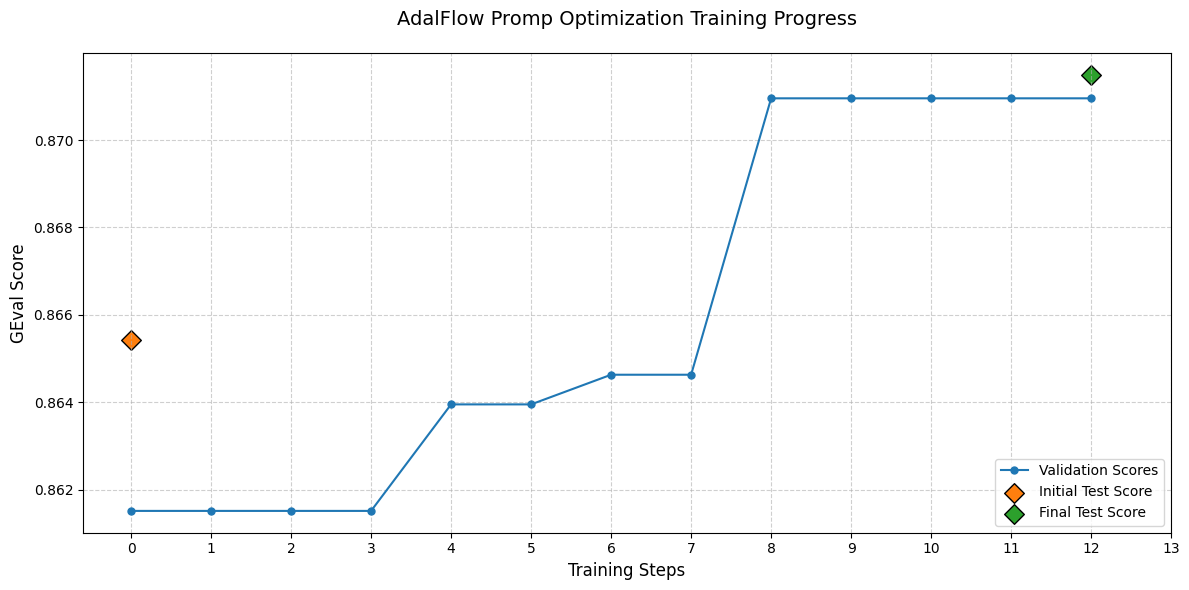

In [16]:
file = 'C:\\Users\\wuhan\\AppData\\Roaming\\adalflow\\ckpt\\HotPotQAAdal\\constrained_max_steps_12_42c34_run_1.json'
plot_training_single(file)

### Understand the JSON Output

In [17]:
with open(file) as f:
    data = json.load(f)
print(data.keys())

dict_keys(['steps', 'val_scores', 'test_scores', 'step_results', 'effective_measure', 'validate_stats', 'time_stamp', 'total_time', 'test_score', 'trainer_state'])


In [18]:
print(data['test_score'])

best_idx = data['val_scores'].index(max(data['val_scores']))
print(best_idx)

best_prompt = data['step_results'][best_idx]['prompt'][0]['data']
initial_prompt = data['step_results'][0]['prompt'][0]['data']
print('Initial Prompt:', initial_prompt)
print('Best Prompt:', best_prompt)

0.8715
8
Initial Prompt: Answer questions with short factoid answers.
                    You will receive context(contain relevant facts).
                    Think step by step.
                
Best Prompt: The total amount of TI dues for September is $1,600,000.


In [19]:
for step in data['step_results']:
    for k, v in step.items():
        if k == 'prompt':
            print(len(v), f"prompt: {v[0]['data']}")
        else:
            print(f"{k}: {v}")
    print()

step: 0
val_score: 0.8615123456790121
test_score: 0.8654166666666667
attempted_val_score: None
1 prompt: Answer questions with short factoid answers.
                    You will receive context(contain relevant facts).
                    Think step by step.
                

step: 1
val_score: 0.8615123456790121
test_score: 0.8654166666666667
attempted_val_score: 0.975
1 prompt: Answer questions with short factoid answers.
                    You will receive context(contain relevant facts).
                    Think step by step.
                

step: 2
val_score: 0.8615123456790121
test_score: 0.8654166666666667
attempted_val_score: 0.975
1 prompt: Answer questions with short factoid answers.
                    You will receive context(contain relevant facts).
                    Think step by step.
                

step: 3
val_score: 0.8615123456790121
test_score: 0.8654166666666667
attempted_val_score: 0.975
1 prompt: Answer questions with short factoid answers.
             